In [208]:
from pymongo import MongoClient
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [209]:
# Mongodb information
client = MongoClient('localhost', 27017)
db = client['twitter']  
streaming_collection = db['streaming']
rest_collection = db['rest']

In [210]:
streaming_list = list(streaming_collection.find())
rest_list = list(rest_collection.find())
combined_list = streaming_list + rest_list

Setting the start time from the first tweet gotten from streaming api and setting the time in increments of 10 mins into a list for future comparion

In [230]:
start_time = None
for tweet in streaming_list:
    start_time = tweet["_id"].generation_time
    break

timelist = [] * 6
for i in range(0,6):
    time = i * 10
    new_time = start_time + timedelta(minutes = time)
    timelist.append(new_time)
timelist

[datetime.datetime(2018, 11, 17, 12, 37, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>),
 datetime.datetime(2018, 11, 17, 12, 47, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>),
 datetime.datetime(2018, 11, 17, 12, 57, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>),
 datetime.datetime(2018, 11, 17, 13, 7, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>),
 datetime.datetime(2018, 11, 17, 13, 17, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>),
 datetime.datetime(2018, 11, 17, 13, 27, 50, tzinfo=<bson.tz_util.FixedOffset object at 0x0000025AF65CE748>)]

Create a function to get the count by comparing the tweet according to the 6 timestamps. 

Starting from the by comparing all tweets from the 50-60 minute mark and work your way down to prevent double count

Return the total number of the database in that time period

In [233]:
def get_count(counting_list, list_of_time):
    total_bucket = [0] * 6
   
    for tweet in counting_list:
        tweet_time = tweet["_id"].generation_time
        for i in range(5,-1,-1):
            if tweet_time > timelist[i]:
                total_bucket[i] +=1
                break

    for i in range(0,5):
        total_bucket[i+1] += total_bucket[i]
    return total_bucket

Get the total count and use the function to seperate in order of 10 mins

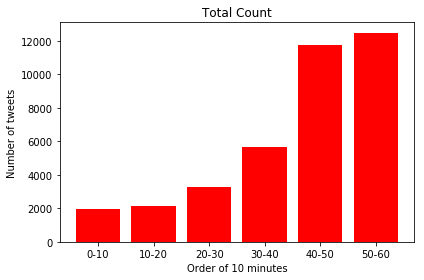

[1932, 2132, 3262, 5633, 11734, 12478]

In [213]:
frequency =["0-10","10-20","20-30","30-40","40-50","50-60"]
total_bucket = get_count(combined_list, timelist)
    
plt.bar(frequency, total_bucket, color='r')
plt.title("Total Count")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()
total_bucket

Go through combined list and check for geo tagged tweets and put them in the count function to seperate in order of 10mins

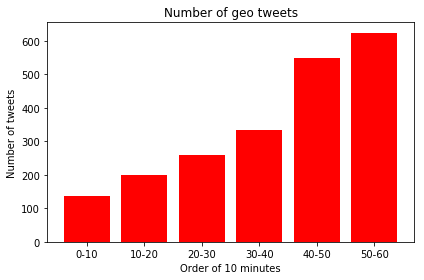

[137, 199, 259, 333, 550, 624]

In [214]:
geo_list = []
for tweets in combined_list:
    if tweets['place'] is not None:
        geo_list.append(tweets)

geo_bucket = get_count(geo_list, timelist)
plt.bar(frequency, geo_bucket, color='r')
plt.title("Number of geo tweets")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()
geo_bucket

Go through the combined list and check for SG geo tagged tweets put them in the count function to seperate in order of 10mins.

\**note this should be the same as the above number in geo tagged tweet in accordance to how I interprete the assignment*

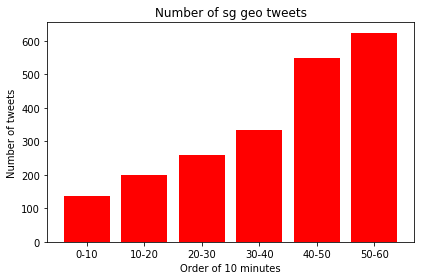

In [215]:
sg_geo_list = []
for tweets in combined_list:
    if tweets['place'] is not None and tweets['place']['country_code'] == "SG":
        sg_geo_list.append(tweets)

sg_geo_bucket = get_count(sg_geo_list, timelist)
plt.bar(frequency, sg_geo_bucket, color='r')
plt.title("Number of sg geo tweets")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()

Go through streaming and add individual tweet id in a set. Go through REST and check if any of the id overlap, if yes then put them in a list. 

Put the list in the count function to seperate in order of 10mins

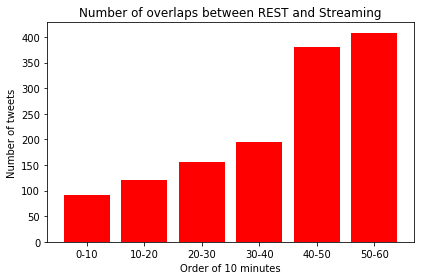

[92, 120, 155, 194, 380, 408]

In [216]:
overlap_list = []
overlap_set = set([])

for tweet in streaming_list:
    overlap_set.add(tweet['id'])

for tweet in rest_list:
    if tweet['id'] in overlap_set:
        overlap_list.append(tweet)

overlap_bucket = get_count(overlap_list, timelist)
plt.bar(frequency, overlap_bucket, color='r')
plt.title("Number of overlaps between REST and Streaming")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()
overlap_bucket

Go through combined list and put every tweet id in a set, if any id existed before then append it to the redundant list

Put the list in the count function to seperate in order of 10mins

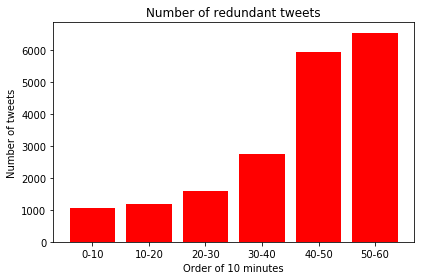

[1064, 1174, 1602, 2744, 5921, 6530]

In [236]:
redundant_list = []
existed = set()
for tweets in combined_list:
    if tweets['id'] not in existed:
        existed.add(tweets['id'])
    else:
        redundant_list.append(tweets)
            
redundant_bucket = get_count(redundant_list, timelist)
plt.bar(frequency, redundant_bucket, color='r')
plt.title("Number of redundant tweets")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()     
redundant_bucket

Get the total all total quoted tweets, put them in a list and run it through count function to seperate in order of 10mins

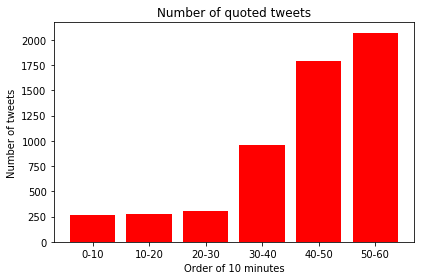

[263, 276, 303, 957, 1789, 2069]

In [237]:
rest_quoted = rest_collection.find({"is_quote_status": True})
streaming_quoted = streaming_collection.find({"is_quote_status": True})
total_quoted = list(rest_quoted) + list(streaming_quoted)

quoted_bucket = get_count(total_quoted, timelist)
plt.bar(frequency, quoted_bucket, color='r')
plt.title("Number of quoted tweets")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()      
quoted_bucket

Get the total all total retweeted tweets, put them in a list and run it through count function to seperate in order of 10mins

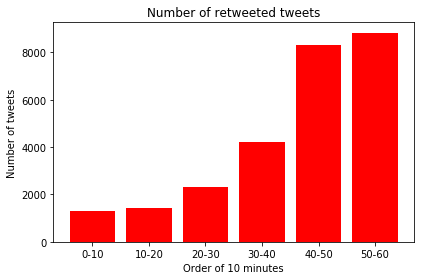

[1296, 1408, 2305, 4210, 8321, 8828]

In [238]:
rest_retweeted = rest_collection.find({"retweeted_status" : {'$ne' : None}})
streaming_retweeted = streaming_collection.find({"retweeted_status" : {'$ne' : None}})
total_retweeted = list(rest_retweeted)+ list(streaming_retweeted)

retweeted_bucket = get_count(total_retweeted, timelist)
plt.bar(frequency, retweeted_bucket, color='r')
plt.title("Number of retweeted tweets")
plt.xlabel("Order of 10 minutes")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()  
retweeted_bucket